In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [3]:
def calcate_fig_shape(cols):
    total_figs = len(cols)
    vlen = int(total_figs**0.5)
    hlen = int(np.ceil(total_figs / vlen))
    print(f"Shape of fig: {(vlen, hlen)}")
    return vlen, hlen

def plot_scatter_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        ax.scatter(pdf[col], pdf['SalePrice'])
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_box_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        all_cats = df[col].unique()
        ax.boxplot([pdf.loc[pdf[col]==c, 'SalePrice'] for c in all_cats], labels=all_cats)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_hist_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        all_cats = df[col].unique()
        counts = df[col].value_counts()
        counts = counts / counts.sum() * 100
        ax.bar(counts.index, counts)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        ax.set_ylabel('%')

    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

In [4]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label).fillna(0).astype(int)

## Data Cleaning
1. NaN values
2. Label the categorical values with order -- 주로 qualitative grade.
    - pd.get_dummy 에서 NaN column사용하는 것도 생각해봐.

In [5]:
train_df = pd.read_csv('rsc/train.csv')
test_df = pd.read_csv('rsc/test.csv')

In [6]:
# Columns with NaN. -- I can only work with training data.
nan_count = train_df.isna().sum()
nan_count_table = (nan_count[nan_count >0] / len(train_df) * 100).round(2).to_frame("NaN Precent [%]")
print("Columns that have NaN values:", )
nan_count_table

Columns that have NaN values:


,NaN Precent [%]
LotFrontage,17.74
Alley,93.77
MasVnrType,0.55
MasVnrArea,0.55
BsmtQual,2.53
BsmtCond,2.53
BsmtExposure,2.60
BsmtFinType1,2.53
BsmtFinType2,2.60
Electrical,0.07


In [7]:
df= pd.concat([train_df, test_df]).reset_index(drop=True)
df.drop(columns=nan_count_table.index, inplace=True)

### Label Qualitative Columns

In [8]:
# columns : labels -- int, qualitative
grading_scheme =[
    (['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1, np.nan:0}),
    (['BsmtExposure'], {'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}),
    (['BsmtFinType1', 'BsmtFinType2'], {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, np.nan:0}),
    (['Functional'], {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}),
    (['GarageFinish'], {'Fin':3, 'RFn':2,'Unf':1, np.nan:0}),
    (['PavedDrive', 'CentralAir'], {'Y':2,'P':1,'N':0}),
    (['Fence'], {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1, np.nan:0})
]
for cols_to_label, label in grading_scheme:
    cols_to_label = df.columns.intersection(cols_to_label)
    label_columns(df, cols_to_label, label)

## Feature Selection
### 1. Categorical

In [9]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index.drop('Id')

First, let's look at the categorical features. I want features that are at least somewhat evenly distributed.\
I don't want any feature that has one category dominating more than 70% of the sample.

In [10]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):].drop(columns=['SalePrice'])

Shape of fig: (4, 5)


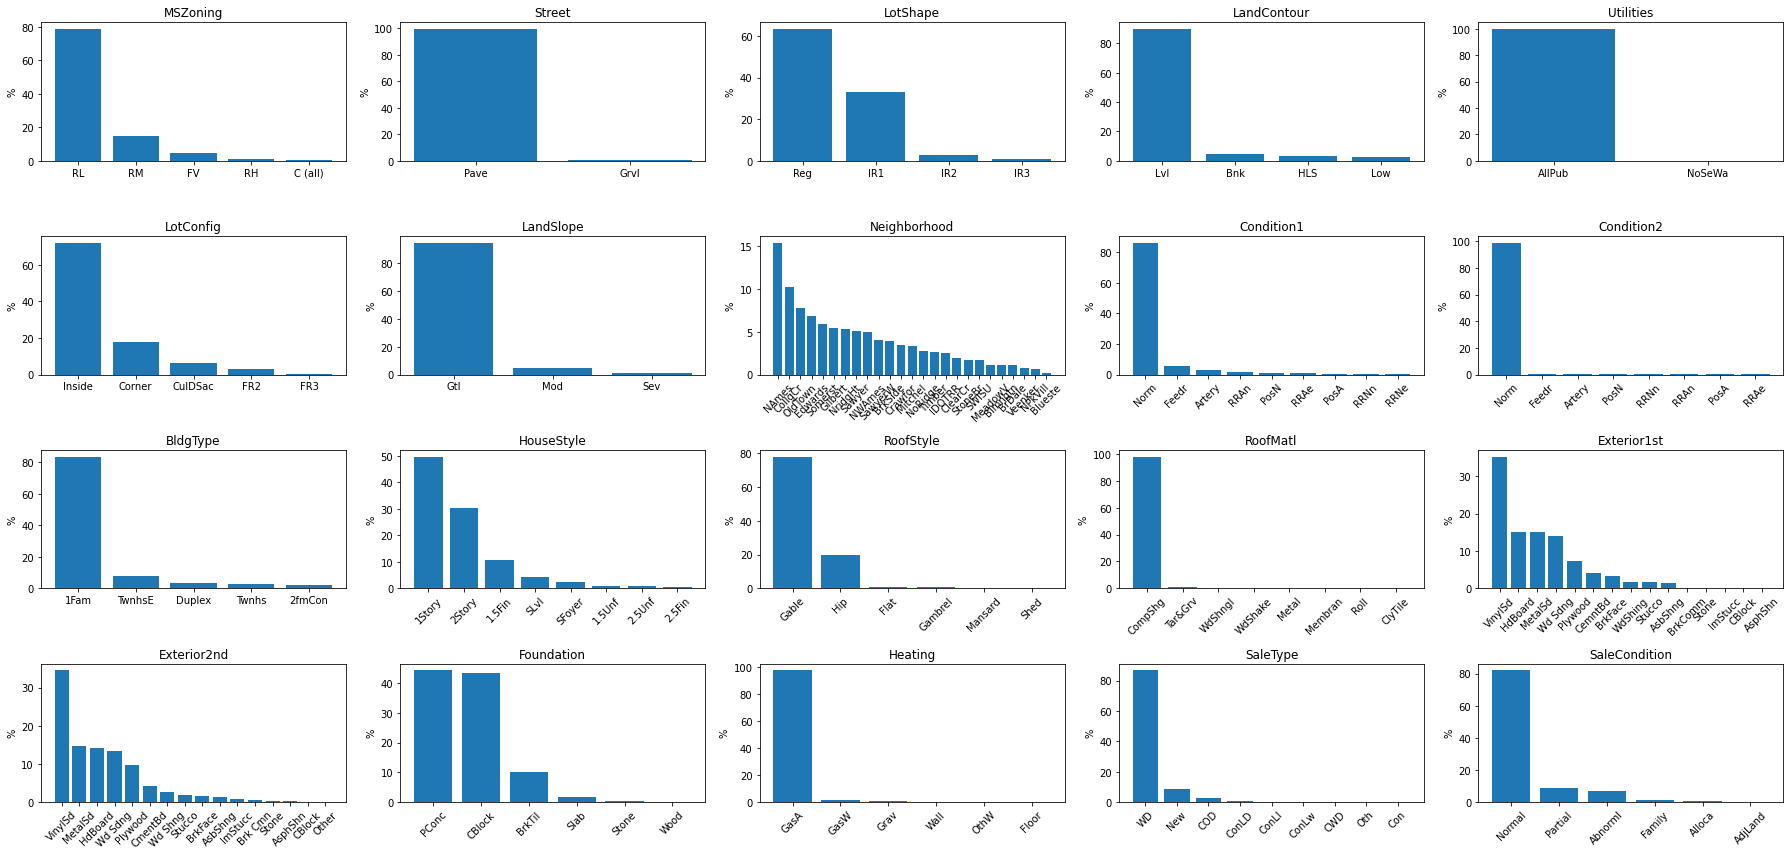

In [11]:
plot_hist_matrix(train_df, categorical_cols)

In [12]:
def find_unevenly_dist_cols(df, cols, thresh = 0.7):
    '''
    Use this for categorical columns
    '''
    uneven_cat_cols = []
    for c in cols:
        counts = df[c].value_counts()
        counts /= counts.sum()
        if (counts > thresh).any():
            uneven_cat_cols.append(c)
    return uneven_cat_cols

In [13]:
uneven_cat_cols = find_unevenly_dist_cols(train_df, categorical_cols, 0.7)
even_cat_cols = set(categorical_cols) - set(uneven_cat_cols)

In [14]:
print('Even categoricals:', even_cat_cols)

Even categoricals: {'Exterior2nd', 'HouseStyle', 'Foundation', 'Neighborhood', 'LotShape', 'Exterior1st'}


Shape of fig: (2, 3)


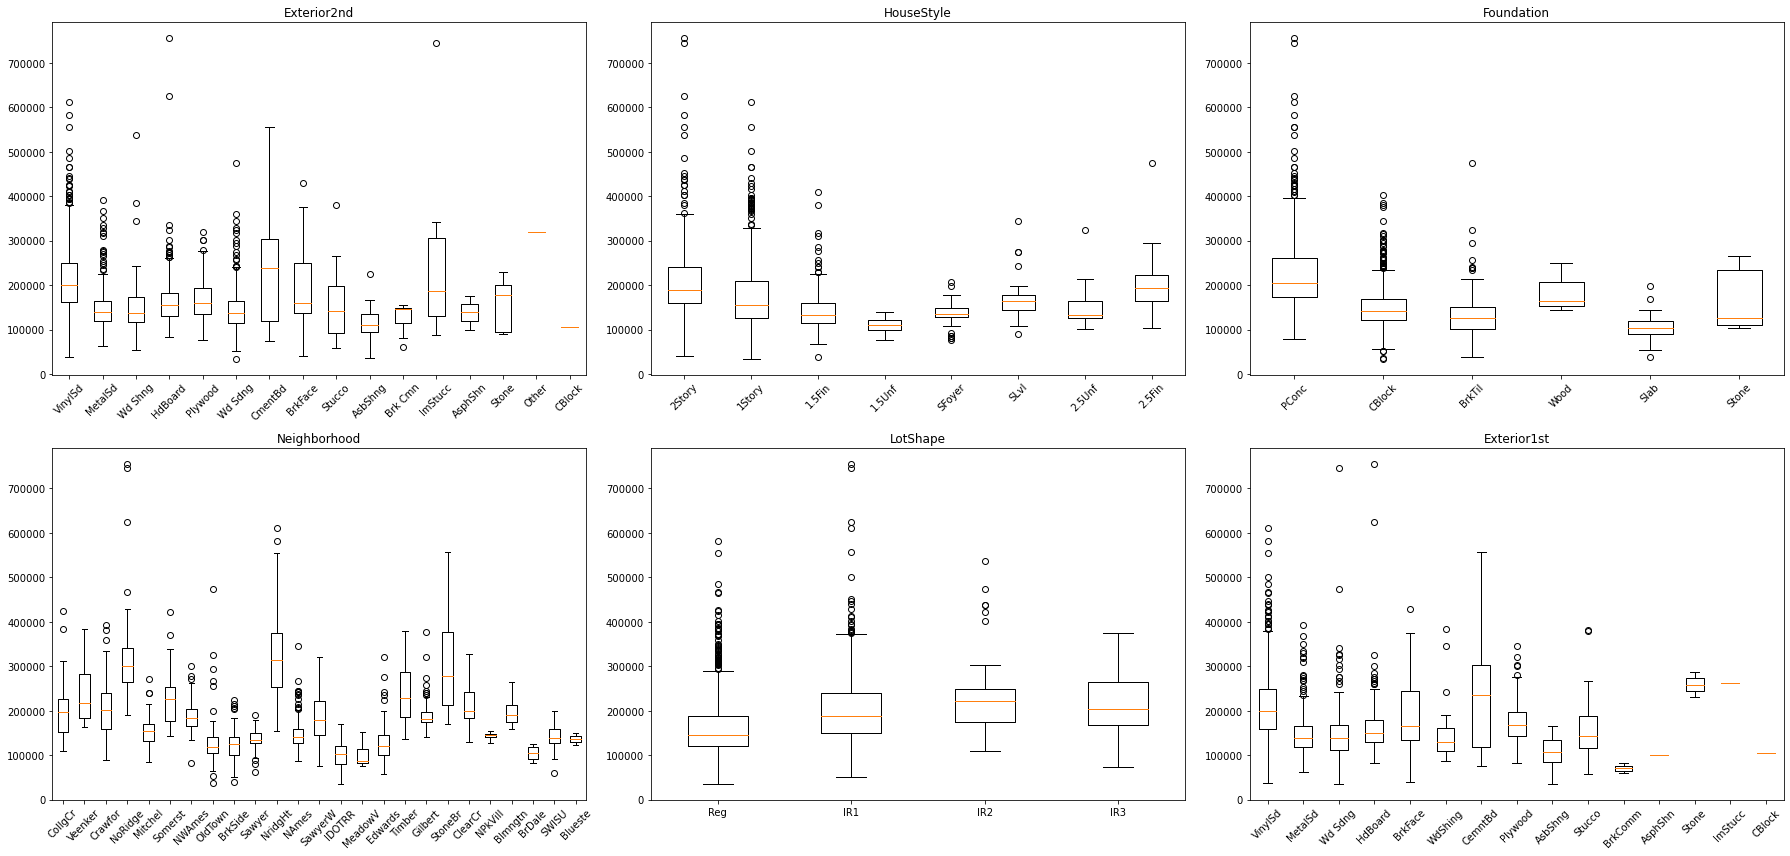

In [15]:
plot_box_matrix(train_df, even_cat_cols)

Most of the features' categories are distinguishing.\
but Exterior features for example, may not be too effective as there are many different categories without significant difference in median.

### 2. Numerical
This set includes qualitative features that were converted to integer values.\
Same procedure goes here. Start with the distribution.

Shape of fig: (6, 7)


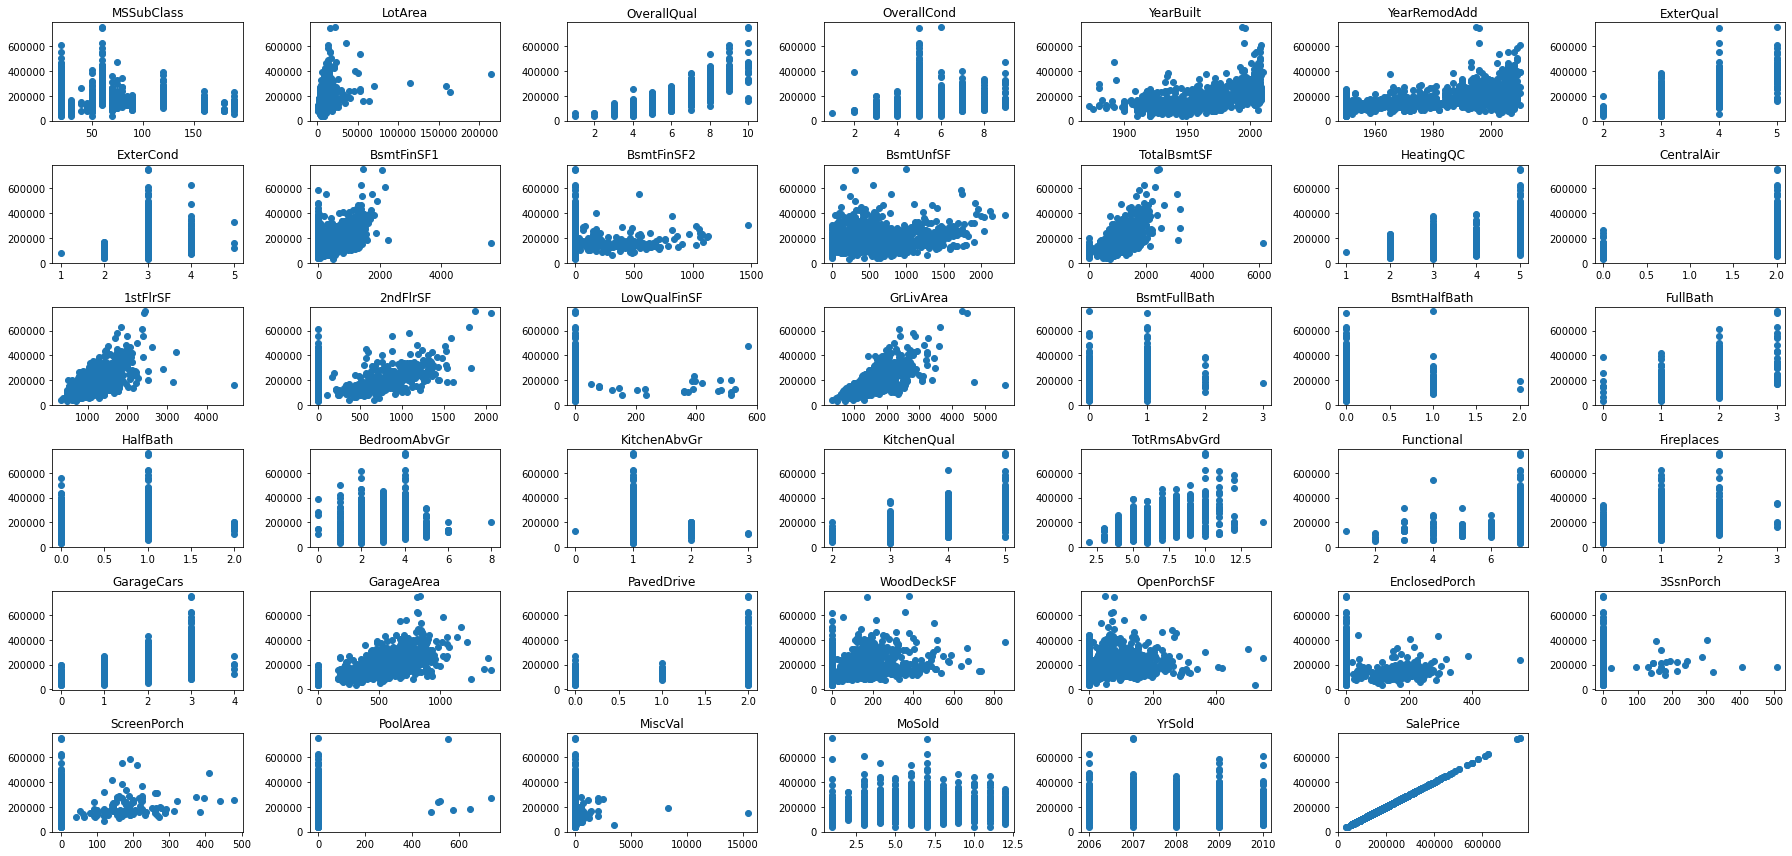

In [16]:
plot_scatter_matrix(train_df, numeric_cols)

It's easy to spot features that have correlations from the graph.\
But let's calculate the correlation coefficient to quantify the relationships.\
I'll be starting with features with correlation coeff higher than 0.5. -- start with the obivous ones.

In [17]:
corr = df[numeric_cols].corr()
strong_numeric_features = corr['SalePrice'][corr['SalePrice'].abs() > 0].index
print("strong numeric features", len(strong_numeric_features))
print(strong_numeric_features.tolist())

strong numeric features 41
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [18]:
def plot_correlation_heatmap(df, cols):
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(df[cols].corr())
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)
    ax.set_title('Correlation plot')
    _ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    _ = cbar.ax.set_ylabel("Pearson score", rotation=-90, va="bottom")

Now, I need to check for colinearity between the strong features.

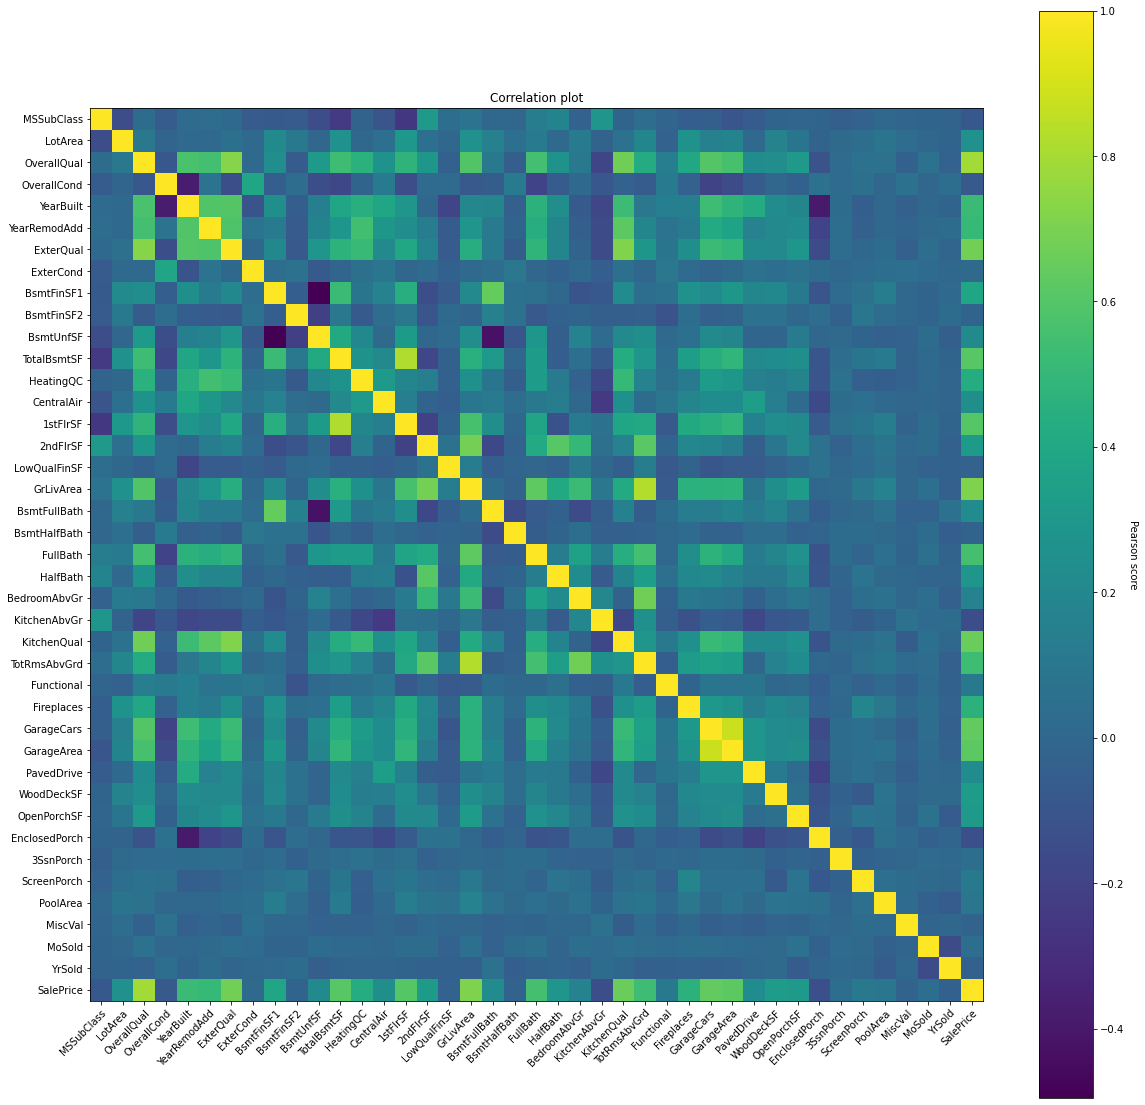

In [19]:
plot_correlation_heatmap(train_df, strong_numeric_features)

There seems to be some correlation between the strong features. I need to avoid this. \
Let's quantify this.

In [20]:
def find_high_collinearity(train_df, cols, corr_thresh=0.7):
    corr = train_df[cols].corr()
    sp = corr['SalePrice']
    high_corr = []
    for index, row in corr.iterrows():
        no_dup = row[index:][1:].drop('SalePrice', errors='ignore')  # index is not numeric
        if (no_dup > corr_thresh).any():
            high_corr_found = no_dup.loc[no_dup.abs() > corr_thresh]
            sale_corr = sp[list(high_corr_found.index) + [index]].to_frame().reset_index()
            sale_corr.rename(columns={sale_corr.columns[0]: 'second feature'}, inplace=True)
            sale_corr['first feature'] = index
            sale_corr.set_index(['first feature', 'second feature'], inplace=True)
            high_corr.append(sale_corr)
    high_corr_df = pd.concat(high_corr)#.reset_index(drop=True)
    high_corr_df = high_corr_df.sort_values('SalePrice', ascending=False)
    return high_corr_df

def handle_collinearity(high_corr_df):
    '''
    returns what columns to use considering collinearity.
    '''
    same_basket = dict()
    selected = dict()
    for idx, row in high_corr_df.iterrows():
        if not idx[0] in same_basket:
            if not idx[1] in selected:
                same_basket[idx[0]]=True
                selected[idx[1]]=True
    return selected

In [21]:
high_corr_df = find_high_collinearity(train_df, strong_numeric_features, 0.7)
high_corr_df

SalePrice
first feature second feature           
OverallQual   OverallQual      0.790982
GrLivArea     GrLivArea        0.708624
OverallQual   ExterQual        0.682639
ExterQual     ExterQual        0.682639
              KitchenQual      0.659600
GarageCars    GarageCars       0.640409
              GarageArea       0.623431
TotalBsmtSF   TotalBsmtSF      0.613581
              1stFlrSF         0.605852
GrLivArea     TotRmsAbvGrd     0.533723

Very interesting. It looks like when Overall Quality is assessed, Exterior Quality is the most emphasized feature. - Makes sense.\
Exterior Quality is strongly correlated to Kitchen Quality. Is it because when they are built/ remodeled, they are the key features that are focused?\
Total Basement SF and 1st Floor SF are correlated because of causality. Foundation == basement >= 1st Floor.
GrLivArea and TotRmsAbvGrd are similarly related. More area to work with -> more rooms can be built.\
Hmmm. Interesting. DNN의 경우에는 multicollinearity에 영향을 받지 않는다고 하네.. source: https://www.cis.upenn.edu/~ungar/Datamining/Publications/tale2.pdf

In [22]:
# selected_numeric = handle_collinearity(high_corr_df)
selected_numeric = strong_numeric_features

In [23]:
to_remove = high_corr_df.index.get_level_values(1).difference(selected_numeric)
strong_no_dup_numeric_cols = strong_numeric_features.difference(to_remove)
# strong_no_dup_numeric_cols = strong_numeric_features.drop('SalePrice')

In [24]:
print("Categoricals, :", even_cat_cols)
print("Numercals, :", set(strong_no_dup_numeric_cols))

Categoricals, : {'Exterior2nd', 'HouseStyle', 'Foundation', 'Neighborhood', 'LotShape', 'Exterior1st'}
Numercals, : {'TotRmsAbvGrd', 'BsmtUnfSF', 'BsmtFinSF1', 'HalfBath', 'OpenPorchSF', 'SalePrice', '2ndFlrSF', 'BedroomAbvGr', 'GarageCars', 'MoSold', 'GarageArea', 'MSSubClass', 'Functional', 'YearBuilt', 'BsmtFullBath', 'BsmtHalfBath', 'LotArea', 'TotalBsmtSF', 'YearRemodAdd', 'KitchenAbvGr', 'OverallQual', 'ExterCond', 'PoolArea', '3SsnPorch', 'WoodDeckSF', '1stFlrSF', 'PavedDrive', 'ScreenPorch', 'EnclosedPorch', 'MiscVal', 'YrSold', 'OverallCond', 'CentralAir', 'KitchenQual', 'GrLivArea', 'Fireplaces', 'HeatingQC', 'FullBath', 'BsmtFinSF2', 'LowQualFinSF', 'ExterQual'}


In [25]:
all_removed_cols = df.columns.difference(strong_no_dup_numeric_cols.union(even_cat_cols))
all_removed_cols = all_removed_cols.union(['SalePrice'])

### 현재까지 feature engineering 결과:
categorical -> even_categorical_cols\
numerical -> numeric_columns

In [39]:
to_one_hot_cols = even_cat_cols
df_onehot = pd.get_dummies(df.drop(columns=all_removed_cols), columns=to_one_hot_cols, drop_first=True)

In [40]:
train_dataset = df_onehot[:len(train_df)]
test_dataset = df_onehot[len(train_df):]
target = df[:len(train_df)]['SalePrice']

# Regression Part

In [117]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
physical_devices = tf.config.list_physical_devices('GPU')
print(f'Tensorflow found {len(physical_devices)} GPU.')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow found 1 GPU.


### Multi variate regression


In [42]:
train_dataset.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,...,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,60,8450,7,5,2003,2003,4,3,706.0,0.0,150.0,856.0,5,2,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,7,0,2.0,548.0,2,0,61,0,0,0,0,0,2,2008,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,20,9600,6,8,1976,1976,3,3,978.0,0.0,284.0,1262.0,5,2,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,7,1,2.0,460.0,2,298,0,0,0,0,0,0,5,2007,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,60,11250,7,5,2001,2002,4,3,486.0,0.0,434.0,920.0,5,2,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,7,1,2.0,608.0,2,0,42,0,0,0,0,0,9,2008,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,70,9550,7,5,1915,1970,3,3,216.0,0.0,540.0,756.0,4,2,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,7,1,3.0,642.0,2,0,35,272,0,0,0,0,2,2006,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,60,14260,8,5,2000,2000,4,3,655.0,0.0,490.0,1145.0,5,2,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,7,1,3.0,836.0,2,192,84,0,0,0,0,0,12,2008,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [76]:
train_input= train_dataset

In [110]:
dnn_norm = Normalization(input_shape=(train_input.shape[1],))
dnn_norm.adapt(train_input.to_numpy())

In [129]:
dnn_model = tf.keras.models.Sequential([
    dnn_norm,
#     Dense(64, activation='relu', input_dim =train_input.shape[1]),
    Dense(64, activation='relu', kernel_initializer='normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='normal'),
    BatchNormalization(),
    Dropout(0.2),
#     Dense(256, activation='relu', kernel_initializer='normal'),
#     Dense(256, activation='relu', kernel_initializer='normal'),
    Dense(1)
])
dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='MAE')

In [130]:
history = dnn_model.fit(train_input, target,
             validation_split=0.2,
             epochs=500,
            batch_size=32,
            verbose=False)

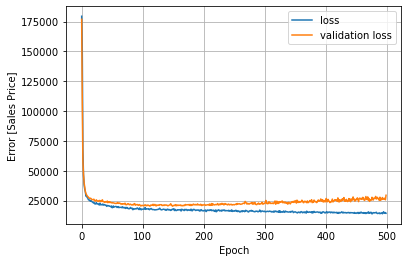

In [131]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)

In [132]:
training_hist.min()

loss        13755.921875
val_loss    20185.916016
dtype: float64

In [133]:
training_hist.tail()

,loss,val_loss
epoch,,
495,15581.850586,26163.998047
496,14436.315430,26878.955078
497,14285.863281,26736.406250
498,14858.781250,25572.693359
499,14341.987305,29408.632812


In [37]:
training_hist.tail()

,loss,val_loss
epoch,,
95,6144.387695,20358.320312
96,6093.012207,20430.798828
97,6134.769043,20601.732422
98,6227.826660,20356.091797
99,5954.540039,20374.332031


In [38]:
test_predictions = dnn_model.predict(test_dataset[final_features]).flatten()
submission = pd.DataFrame(test_predictions, index=test_dataset.index+2, columns=['SalePrice'])
submission.index.name = 'Id'
submission.head()

NameError: name 'final_features' is not defined